In [1]:
import os
import requests
import numpy as np
import pandas as pd
import rasterio as rio
from rasterio.plot import show
from rasterio.transform import from_bounds
from shapely.geometry import box
import matplotlib.pyplot as plt

In [2]:
data_lookup = pd.read_csv("./Data/data_lookup.csv", sep="|")
data_lookup.DSM = data_lookup[data_lookup.DSM.isnull() == False].DSM.apply(lambda x:"./Data" +x[1:])
root = data_lookup[data_lookup.PATH == "ROOT"]

In [3]:
class Box:
    def __init__(self, bounds=None, left:int=0, bottom:int=0, right:int=0, top:int=0):
        if bounds is not None: self.left,self.bottom,self.right,self.top = bounds
        else: self.left,self.bottom,self.right,self.top = left,bottom,right,top
        self.width, self.height = self.right -self.left, self.top -self.bottom
    @classmethod
    def around_point(cls, x:int, y:int, size:int):
        return Box(None, x-size/2, y-size/2, x+size/2, y+size/2)
    @classmethod
    def from_string(cls, string:str=""):
        string = string.split(" ")
        return Box(None,
            int(string[0]),
            int(string[1]),
            int(string[2]),
            int(string[3]))
    def __repr__(self):
        return "{} {} {} {} {} {}".format(
            str(int(self.left)),
            str(int(self.bottom)),
            str(int(self.right)),
            str(int(self.top)),
            str(int(self.width)),
            str(int(self.height)))
    def __str__(self):
        return "left:{} bottom:{} right:{} top:{} width:{} height:{}".format(
            self.left, self.bottom, self.right, self.top, self.width, self.height)
    def contains_point(self, x:int, y:int) -> bool:
        return self.left <= x < self.right and self.bottom <= y < self.top
    def contains_box(self, other) -> bool:
        return other.left >= self.left and other.bottom >= self.bottom and other.right <= self.right and other.top <= self.top

In [4]:
def get_lambert(address:str) -> (int,int):
    req = requests.get(f"http://loc.geopunt.be/geolocation/location?q={address}&c=1")
    return (req.json()["LocationResult"][0]["Location"]["X_Lambert72"],
            req.json()["LocationResult"][0]["Location"]["Y_Lambert72"])

In [5]:
def crop_location(tif, width:int=200, height:int=200) -> rio.io.DatasetReader:
    arr = np.array(tif.read(1))
    meta, bounds = tif.meta, tif.bounds
    posx, posy = int(x -bounds.left), int(abs(y -bounds.top))
    slicex = slice(posx -width//2, posx +width//2)
    slicey = slice(posy -height//2, posy +height//2)
    meta["width"], meta["height"] = width, height
    meta["transform"] = from_bounds(
        bounds.left + slicex.start,
        bounds.top - slicey.stop,
        bounds.left + slicex.stop,
        bounds.top - slicey.start,
        width, height)
    with rio.open("./crop.tif", "w", **meta) as crop:
        crop.write(arr[slicey,slicex], indexes=1)
    return rio.open("./crop.tif")

In [6]:
def get_tif_from_point(x:int, y:int) -> rio.io.DatasetReader:
    return rio.open(data_lookup[
        data_lookup.BOX.apply(lambda b:Box.from_string(b).contains_point(x,y))
       &data_lookup.PATH.apply(lambda p:p != "ROOT")].DSM.values[0])

def get_neighbour(tif, direction:str) -> rio.io.DatasetReader:
    box = Box(tif.bounds)
    point = {"left": (box.left -10, box.top -box.height/2),
             "bottom": (box.right -box.width/2, box.bottom -10),
             "right": (box.right +10, box.top -box.height/2),
             "top": (box.right -box.width/2, box.top +10)}
    return get_tif_from_point(*point[direction])

def get_containing_tif(x:int, y:int, size:int=100) -> {rio.io.DatasetReader}:
    main = get_tif_from_point(x,y)
    print(main)
    box = Box(main.bounds)
    crop_box = Box.around_point(x,y,size)
    if Box(main.bounds).contains_box(crop_box): return main

    result = {}
    if crop_box.left < box.left: result["left"]  = get_tif_from_point(crop_box.left, y)
    if crop_box.bottom < box.bottom: result["bottom"]  = get_tif_from_point(x, crop_box.bottom)
    if crop_box.right > box.right: result["right"]  = get_tif_from_point(crop_box.right, y)
    if crop_box.top > box.top: result["top"]  = get_tif_from_point(x, crop_box.top)
    
    for k, v in result.items():
        return concat_tifs((main, v), k)

x, y = get_lambert("Molenstraat 52, Sint-Kat")
tifs = get_containing_tif(x,y)

<open DatasetReader name='./Data/k24/0_0_2_1_3/DSM.tif' mode='r'>


In [7]:
align = {"left": (1,0,1),"bottom": (0,1,0),"right": (0,1,1),"top": (1,0,0)}
def concat_tifs(tifs:(), key:str) -> rio.io.DatasetReader:
    meta = tifs[0].meta
    meta["width"] *= 2 if key is "left" or key is "right" else 1
    meta["height"] *= 2 if key is "bottom" or key is "top" else 1
    meta["transform"] = from_bounds(
        tifs[align[key][0]].bounds.left,
        tifs[align[key][1]].bounds.bottom,
        tifs[align[key][1]].bounds.right,
        tifs[align[key][0]].bounds.top,
        meta["width"], meta["height"])
    arr = np.concatenate((
        np.array(tifs[align[key][0]].read(1)),
        np.array(tifs[align[key][1]].read(1))),
        axis=align[key][2])
    with rio.open("./temp.tif", "w", **meta) as temp:
        temp.write(arr, indexes=1)
    return rio.open("./temp.tif")

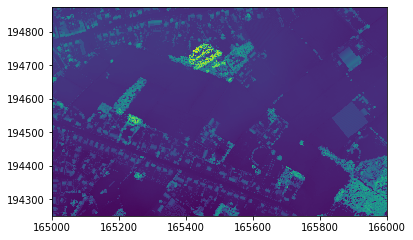

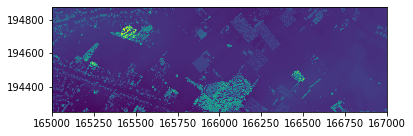

BoundingBox(left=165000.0, bottom=194250.0, right=167000.0, top=194875.0)

In [12]:
x, y = get_lambert("Molenstraat 52 Sint-Kat")
tif = get_tif_from_point(x,y)
show(tif)
concat = concat_tifs((tif, get_neighbour(tif,"right")), "right") 
show(concat)
concat.bounds

Address : Bosstraat 45 Duffel
Crop size: 100
<open DatasetReader name='./Data/k23/1_1_0_1_1/DSM.tif' mode='r'>


AttributeError: 'AxesImage' object has no property 'figsize'

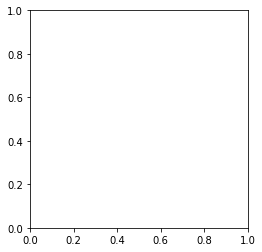

In [13]:
x, y = get_lambert(input("Address : "))
size = int(input("Crop size: "))
tif = get_containing_tif(x, y, size)
plt.figure(figsize=(8,8))
show(crop_location(tif,size,size), cmap="cividis")